### Notebook to detect identical Genotypes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel
import itertools as it
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-e-16-229.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


In [2]:
def get_idx_iid(f,sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:])
    idx = samples.str.contains(sample)
    idx = np.where(idx)[0]
    if unique:
        assert(len(idx)==1)
        return idx[0]
    else:
        return idx
    
def get_exact_idx_iid(f, sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:].astype("str"))
    idx = samples==sample
    idx = np.where(idx)[0]
    assert(len(idx)==1)
    return idx
    
def get_coverage(f, j):
    """Get Coverage of sample j in hdf5 f"""
    ads =  f["calldata/AD"][:,j,:]
    ads[ads<0]=0
    cov = np.mean(ads)*2
    return cov

def get_markers_good(f, j, output=True, cutoff=0.99):
    """Get markers"""
    m = np.max(f["calldata/GP"][:,j,:], axis=1)
    idx = (m>cutoff)
    if output:
        c1 = np.mean(m>cutoff)
        print(f"Filtering to {cutoff} GP variants: {c1:.3f}x")
    return idx

def get_fraction_identical(f, sample1="SUC006", sample2="R26.SG", 
                           gp_cutoff=0.98, output=False):
    """Get Fraction of Identical Genotype Configurations.
    Return Fraction same IID, and fraction SNPs both IIDs tested"""
    if output:
        print(f"Running {sample1}-{sample2}")
    j1 = get_exact_idx_iid(f, sample1)[0]
    j2 = get_exact_idx_iid(f, sample2)[0]
    
    idx1 = get_markers_good(f, j1, cutoff=gp_cutoff, output=output)
    idx2 = get_markers_good(f, j2, cutoff=gp_cutoff, output=output)
    idx = (idx1 & idx2)
    snp_frac = np.mean(idx)
    if output:
        print(f"Filtering to common GP variants: {snp_frac:.3f}x")
    
    gt1 = f["calldata/GT"][:, j1, :][idx,:]
    gt2 = f["calldata/GT"][:, j2, :][idx,:]
    g1, g2 = np.sum(gt1, axis=1), np.sum(gt2, axis=1)
    frac_same = np.mean(g1 == g2)
    return frac_same,snp_frac

# Calculate Fraction Identical for all individuals in list of pairs
Run one time

In [3]:
df = pd.read_csv("./output/dumpster/full_run_ch3_9813/o_homo_all_0005.tsv", sep="\t")
print(f"Loaded {len(df)} PO or identical Individuals")

Loaded 1603 PO or identical Individuals


In [58]:
%%time
f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!
y = [get_fraction_identical(f, sample1=iid1, sample2=iid2, cutoff=0.98)
                                     for iid1, iid2 in df[["iid1","iid2"]].values]
y=np.array(y)
identical=y[:,0]
snp_frac=y[:,1]
f.close()

CPU times: user 11min 17s, sys: 1min 42s, total: 12min 59s
Wall time: 13min 34s


In [59]:
df["gt_match_rate_ch3"] = identical
df["frac_snps_good_ch3"] = snp_frac

In [ ]:
df.sort_values(by="gt_match_rate_ch3", ascending=False)[:30]

In [19]:
savepath ="./output/relatives_snp/opp_homos_ch3.tsv"
df.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df)} opp. homo pairs to {savepath}")

Saved 1603 opp. homo pairs to ./output/relatives_snp/opp_homos_ch3.tsv


# Process the similarity list

In [4]:
savepath ="./output/relatives_snp/opp_homos_ch3.tsv"
df = pd.read_csv(savepath, sep="\t")

In [5]:
idx_identical = df["gt_match_rate_ch3"]>0.98
print(f"Found identical indivdiuals {np.sum(idx_identical)}")

Found identical indivdiuals 1179


In [6]:
df[df["iid2"].str.contains("I2312_all_d.SG")]

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3
1458,I1293_all_d.SG,I2312_all_d.SG,0.0,0.966001,0.521995


# Check Punic Samples

In [3]:
version = "54.1"
path_meta = f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v{version}.tsv"

df_meta = pd.read_csv(path_meta, sep="\t")
print(f"Loaded {len(df_meta)} IIDs from Meta")

# Load the Kerouene Data
dft = df_meta[df_meta["loc"].str.contains("Kerkouene|Kerkouane|Cap Bon")]
print(f"Loaded {len(dft)} Kerkouene IIDs")
iids = dft["iid"].values

Loaded 10156 IIDs from Meta
Loaded 40 Kerkouene IIDs


In [4]:
def get_match_df(path_h5="./data/hdf5/1240k_v54.1/ch", ch=3,
                 iids=[], gp_cutoff=0.98):
    """Create diploid Match Rate for all pairs in list of iids"""

    iids1, iids2, ms, os = [],[],[],[]

    with h5py.File(f"{path_h5}{ch}.h5", "r") as f:
        for iid1,iid2 in it.combinations(iids, r=2): 

            m,o = get_fraction_identical(f, sample1=iid1, sample2=iid2, 
                                   gp_cutoff=gp_cutoff, output=False)# Load for Sanity Check. See below!
            iids1.append(iid1)
            iids2.append(iid2)
            ms.append(m)
            os.append(o)

    dft = pd.DataFrame({"iid1":iids1,"iid2":iids2, "frac_match":ms, "frac_snps":os})
    return dft

In [47]:
%%time
dft = get_match_df(ch=3, iids=iids)

CPU times: user 59.5 s, sys: 767 ms, total: 1min
Wall time: 1min 3s


In [48]:
dft.sort_values(by="frac_match",ascending=False)[:50]

,iid1,iid2,frac_match,frac_snps
389,I24045,R11791.SG,0.999049,0.856539
183,I24040,R11780.SG,0.998983,0.864206
495,I24033,R11755.SG,0.998890,0.792398
104,I24041,R11753.SG,0.998878,0.899088
598,I24031,R11746.SG,0.998729,0.762842
331,I24044,R11790.SG,0.998657,0.837262
462,I24049,R11776.SG,0.998597,0.811210
574,I24036,R11759.SG,0.998475,0.746293
534,I24048,R11749.SG,0.998238,0.777659
519,I24039,R11778.SG,0.997993,0.766565


### Check all Punic Samples

In [10]:
dft = get_match_df(ch=1, iids=["I26932", "I27617", "I27613"])

In [11]:
dft

,iid1,iid2,frac_match,frac_snps
0,I26932,I27617,0.823502,0.344211
1,I26932,I27613,0.664297,0.790901
2,I27617,I27613,0.997101,0.343397


# Area 51

### Plot identical individuals

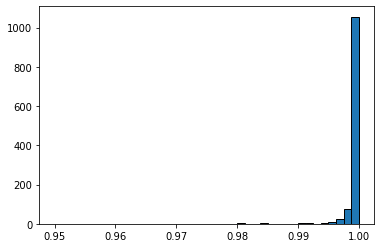

In [7]:
bins=np.linspace(0.95,1,41)
plt.figure()
ax=plt.gca()
ax.hist(df["gt_match_rate_ch3"], ec="k",bins=bins)
plt.show()

# Explore Pavel's identical Individuals

In [23]:
%%time
dft = pd.read_csv("./notebook/detect_snp_rel/ibd_problem_pavel.22.10.tsv", sep="\t")[:-4]
print(f"Loaded {len(dft)} pairs")

ch = 3



f = h5py.File(f"./data/hdf5/1240k_v53.1/ch{ch}.h5", "r") # Load for Sanity Check. See below!
y = [get_fraction_identical(f, sample1=iid1, sample2=iid2, cutoff=0.98, output=False)
                                     for iid1, iid2 in dft[["iid1","iid2"]].values]
y=np.array(y)
identical=y[:,0]
snp_frac=y[:,1]
f.close()

dft["identicalGT"]=identical
dft["commonSNP>0.98GP"]=snp_frac # 0.861

Loaded 30 pairs
CPU times: user 2.72 s, sys: 51.8 ms, total: 2.77 s
Wall time: 2.77 s


In [25]:
dft[["iid1","iid2","identicalGT", "commonSNP>0.98GP"]]

,iid1,iid2,identicalGT,commonSNP>0.98GP
0,A181018,I18224,1.000000,0.861374
1,A181019,I18225,1.000000,0.855918
2,A181022,I16744,0.999927,0.883018
3,A181023,I16750,1.000000,0.875170
4,A181024,I16751,0.999985,0.877225
5,A181025,I16752,0.999985,0.884440
6,A181026,I16753,1.000000,0.899399
7,A181027,I16759,1.000000,0.769630
8,A181028,I16812,1.000000,0.888655
9,A181014,I18184,1.000000,0.809037


In [ ]:
f = h5py.File(f"./data/hdf5/1240k_v53.1/ch{ch}.h5", "r") # Load for Sanity Check. See below!
for iid in dft["iid1"]:
    there = iid in f["samples"][:].astype("str")
    print(f"{iid} there: {there}")
f.close()

ValueError: Invalid location identifier (invalid location identifier)